In [3]:
# !pip install sklearn pandas matplotlib

In [1]:
import pandas as pd
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import train_test_split
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
from utilities import *
import seaborn as sns

## global vars

In [2]:
TEST_SIZE=0.2

## read the training data


In [3]:
data = pd.read_csv("train/train.csv").dropna()
data.head()

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4521252780,1,11,2,0,5,5,1,0,0,...,0,15521,6.8,18175,222,48,-544,-2063,22.2,1552.1
1,4516789805,1,17,2,0,9,4,8,1,0,...,0,15946,6.6,17106,230,52,-3538,-2904,23.0,1594.6
2,4517546735,1,85,6,1,9,1,11,1,1,...,0,13584,7.0,17661,217,42,-5240,-2335,21.7,1358.4
3,4508668617,0,17,3,0,6,4,8,0,0,...,0,15036,6.8,17006,225,40,-1954,-1045,22.5,1503.6
4,4462493939,0,16,2,0,8,9,8,0,0,...,0,18704,7.2,19776,226,52,1720,1376,22.6,1870.4


In [4]:
X,y = separate_feature_label(data, "blueWins")

## preprocessing and analysis

### get the attributes with low correlation only


In [5]:
X.corr()

,gameId,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,1.000000,0.007581,-0.013135,-0.018784,-0.037425,-0.007525,-0.021807,0.018099,0.007826,0.019485,...,0.012256,-0.004728,-0.011294,-0.018711,-0.003173,0.006975,0.017056,0.014081,-0.003173,-0.004728
blueWardsPlaced,0.007581,1.000000,0.032123,0.004943,0.023941,-0.005017,0.038240,0.028595,0.022466,0.018317,...,-0.004308,-0.006268,-0.006229,-0.012416,-0.006672,-0.007647,-0.020250,-0.031875,-0.006672,-0.006268
blueWardsDestroyed,-0.013135,0.032123,1.000000,0.012506,0.031649,-0.073581,0.064145,0.045746,0.046060,0.016814,...,-0.020540,-0.065585,-0.055534,-0.054776,0.042606,-0.030970,-0.078238,-0.076629,0.042606,-0.065585
blueFirstBlood,-0.018784,0.004943,0.012506,1.000000,0.273073,-0.242378,0.232058,0.151444,0.134443,0.077931,...,-0.066938,-0.296067,-0.184038,-0.197454,-0.161111,-0.020350,-0.377410,-0.236841,-0.161111,-0.296067
blueKills,-0.037425,0.023941,0.031649,0.273073,1.000000,0.013922,0.813396,0.179939,0.173738,0.075316,...,-0.079644,-0.154185,-0.408170,-0.457306,-0.469307,-0.211618,-0.650809,-0.578788,-0.469307,-0.154185
blueDeaths,-0.007525,-0.005017,-0.073581,-0.242378,0.013922,1.000000,-0.019324,-0.195207,-0.182452,-0.089147,...,0.160615,0.886486,0.430090,0.461086,-0.047855,-0.096700,0.637527,0.571749,-0.047855,0.886486
blueAssists,-0.021807,0.038240,0.064145,0.232058,0.813396,-0.019324,1.000000,0.151175,0.172465,0.030572,...,-0.060404,-0.129170,-0.358108,-0.394357,-0.332054,-0.163045,-0.547007,-0.433073,-0.332054,-0.129170
blueEliteMonsters,0.018099,0.028595,0.045746,0.151444,0.179939,-0.195207,0.151175,1.000000,0.783979,0.642645,...,-0.048433,-0.206448,-0.161744,-0.182974,-0.069156,-0.089088,-0.278051,-0.259519,-0.069156,-0.206448
blueDragons,0.007826,0.022466,0.046060,0.134443,0.173738,-0.182452,0.172465,0.783979,1.000000,0.028196,...,-0.029924,-0.185852,-0.141129,-0.152507,-0.055342,-0.099549,-0.234174,-0.209230,-0.055342,-0.185852
blueHeralds,0.019485,0.018317,0.016814,0.077931,0.075316,-0.089147,0.030572,0.642645,0.028196,1.000000,...,-0.041055,-0.103051,-0.086265,-0.106406,-0.043054,-0.020588,-0.158709,-0.159653,-0.043054,-0.103051


In [6]:
corrTable = X.corr()
cols = X.columns

In [7]:
newCols = []
for i in cols:
    for j in cols:
        if( i!=j and abs(corrTable[i][j])<0.01 ):
            newCols.append(j)
newCols = list( pd.Series(newCols).unique() )
print( len(newCols) )
X = X[newCols]

29


In [8]:
len(cols) , len(newCols)
diff_col = [col for col in cols if col not in newCols]
diff_col

['blueKills',
 'blueTotalGold',
 'blueGoldDiff',
 'blueExperienceDiff',
 'blueGoldPerMin',
 'redDeaths',
 'redEliteMonsters',
 'redDragons',
 'redGoldDiff',
 'redExperienceDiff']

## remove the outliers


<AxesSubplot:xlabel='blueWardsPlaced'>

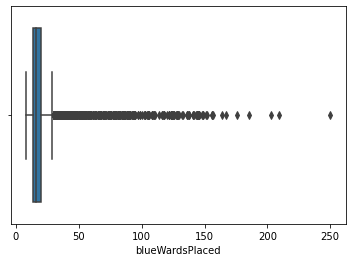

In [9]:
sns.boxplot(x=X[newCols[0]])


### inital model


In [12]:

treeClassifier = tree.DecisionTreeClassifier(
    min_samples_leaf=100, max_depth=10
)
X_train, X_test, y_train, y_test =train_test_split( X, y, test_size=TEST_SIZE, random_state=42)


### parameter tuning and validation


In [13]:
parameters = {'max_depth':[10,11,12,20], 
              'min_samples_leaf':[50,100,150], 
              'min_samples_split':[10,50,100,150,200,250],
              'criterion' : ['gini','entropy']}
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(treeClassifier, parameters, scoring=scorer)
fit_obj = search_obj.fit(X_train, y_train)
best_clf = fit_obj.best_estimator_

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, best_clf.predict(X_test)) ) )


Accuracy for tree classifier: 0.7115749525616698


In [14]:
test_this_model(best_clf, newCols)

Accuracy for tree classifier: 0.7130566801619433


## final classifier

In [15]:
treeClassifier = best_clf

[Text(0.4554794520547945, 0.9444444444444444, 'X[16] <= 1576.85\nentropy = 1.0\nsamples = 6322\nvalue = [3161, 3161]'),
 Text(0.1952054794520548, 0.8333333333333334, 'X[26] <= 18651.5\nentropy = 0.822\nsamples = 2086\nvalue = [536, 1550]'),
 Text(0.1095890410958904, 0.7222222222222222, 'X[23] <= 16909.0\nentropy = 0.926\nsamples = 1167\nvalue = [398, 769]'),
 Text(0.0547945205479452, 0.6111111111111112, 'X[26] <= 17813.5\nentropy = 0.754\nsamples = 434\nvalue = [94, 340]'),
 Text(0.0273972602739726, 0.5, 'X[16] <= 1491.35\nentropy = 0.906\nsamples = 202\nvalue = [65, 137]'),
 Text(0.0136986301369863, 0.3888888888888889, 'entropy = 0.778\nsamples = 100\nvalue = [23, 77]'),
 Text(0.0410958904109589, 0.3888888888888889, 'entropy = 0.977\nsamples = 102\nvalue = [42, 60]'),
 Text(0.0821917808219178, 0.5, 'X[2] <= 0.5\nentropy = 0.544\nsamples = 232\nvalue = [29, 203]'),
 Text(0.0684931506849315, 0.3888888888888889, 'entropy = 0.704\nsamples = 115\nvalue = [22, 93]'),
 Text(0.095890410958904

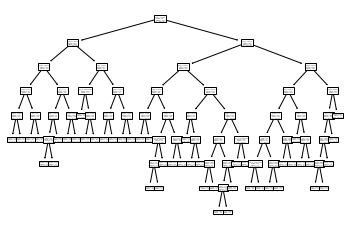

In [16]:
tree.plot_tree(treeClassifier)


## DecisionTree model testing on unseen data

In [17]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, treeClassifier.predict(X_test)) ) )


Accuracy for tree classifier: 0.7130566801619433


# Logistic Regression

In [18]:
from sklearn.metrics import accuracy_score
# fit logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

## building the model

In [19]:

scaler = MinMaxScaler()
X_reg = X[newCols]
y_reg = y
scaler.fit(X_reg)
X_reg = scaler.transform(X_reg)

X_train, X_test, y_train, y_test = train_test_split(X_reg, y_reg, test_size=TEST_SIZE, random_state=42)

In [20]:

logisticRegressor = LogisticRegression()
logisticRegressor.fit(X_train, y_train)

# get accuracy score
pred_lm = logisticRegressor.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7273877292852625


## LogisticRegression model testing on unseen data

In [21]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for LogisticRegression classifier: "+str( metrics.accuracy_score(y_test, logisticRegressor.predict(X_test)) ) )


Accuracy for LogisticRegression classifier: 0.7338056680161943


# Adaboost Classifier

In [22]:
from sklearn.ensemble import AdaBoostClassifier

## Model tuning

In [23]:
print(len(newCols))

29


In [24]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

ababooster.fit(X_train, y_train)

# get accuracy score
pred_lm = ababooster.predict(X_test)
acc_lm = accuracy_score(pred_lm, y_test)
print(acc_lm)

0.7277327935222672


In [25]:
ababooster = AdaBoostClassifier(n_estimators=100, random_state=42)

parameters = {
        'n_estimators':[90,100,150],
        'base_estimator':[tree.DecisionTreeClassifier( max_depth=1),tree.DecisionTreeClassifier( max_depth=2)]
            }
scorer = make_scorer(f1_score)

search_obj = RandomizedSearchCV(ababooster, parameters, scoring=scorer)
fit_obj = search_obj.fit(X_train, y_train)
best_clf = fit_obj.best_estimator_

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, best_clf.predict(X_test)) ) )


/home/mohammed/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy for tree classifier: 0.728744939271255


In [26]:
print(fit_obj.cv_results_)

{'mean_fit_time': array([1.02593341, 1.28318238, 1.89358268, 2.42616773, 2.44506764,
       3.11209898]), 'std_fit_time': array([0.08679626, 0.06537423, 0.14634611, 0.25347505, 0.39089284,
       0.13302109]), 'mean_score_time': array([0.04583559, 0.06773996, 0.07635245, 0.06331153, 0.07573733,
       0.0783277 ]), 'std_score_time': array([0.01169488, 0.01650842, 0.00925841, 0.02058631, 0.03286712,
       0.01694443]), 'param_n_estimators': masked_array(data=[90, 100, 150, 90, 100, 150],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_base_estimator': masked_array(data=[DecisionTreeClassifier(max_depth=1),
                   DecisionTreeClassifier(max_depth=1),
                   DecisionTreeClassifier(max_depth=1),
                   DecisionTreeClassifier(max_depth=2),
                   DecisionTreeClassifier(max_depth=2),
                   DecisionTreeClassifier(max_depth=2)],
             mask=[False, False, F

In [27]:
ababooster=best_clf

In [28]:

test_data = pd.read_csv("test/test.csv").dropna()


X_test,y_test = separate_feature_label(test_data, "blueWins")
X_test = X_test[newCols]
X_test = scaler.transform(X_test)

print( "Accuracy for tree classifier: "+str( metrics.accuracy_score(y_test, ababooster.predict(X_test)) ) )


Accuracy for tree classifier: 0.728744939271255
